# Forecasting the number of taxi orders

## ***Introduction***

### *Project Description:*
    The company "Chyotenkoe Taxi" collected historical data on taxi orders at airports. In order to attract more drivers during peak periods, it is necessary to predict the number of taxi orders for the next hour. Build a model for such a prediction.
    The value of the RMSE metric on the test sample should not exceed 48.
### *Project Goal:*
    Build a model for predicting the number of taxi orders for the next hour.
### *Data Description:*
    Data in the taxi.csv table:
        datetime - data collection date
        num_orders - number of orders
### *Work Plan:*
    1. Data preparation:
        - data upload, general information study
        - creation of new features
        - stationarity test
    2. Data analysis:
        - exploratory analysis
        - correlation analysis
    3. Model training
    4. Testing
    5. General conclusion

In [1]:
! pip install -q sweetviz
! pip install -q phik
! pip install -q lightgbm
! pip install -q --upgrade scikit-learn
! pip install -q optuna-integration


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Imports from the standard library
import os
import warnings

# Importing third-party libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Analysis
import sweetviz as sv
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from statsmodels.tsa.stattools import adfuller, kpss

# Time series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

# Data preparation and search
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from optuna.integration import OptunaSearchCV

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import mean_squared_error, make_scorer

## Preparation

### Loading data

We'll get the data and immediately set the dates as table indexes.

In [3]:
if os.path.exists('/datasets/taxi.csv'):
    df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
else:
    df_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Let's take a look at the table

In [4]:
pd.set_option('display.max_columns', None)
df_taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


All declared features are present, column names are normal

In [5]:
display(df_taxi.info(), df_taxi.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


There are no gaps. There are not enough features to train the model. Let's add some features.

### Creating Features

Before creating features, we sort the table by index and resample the data by one hour.

In [6]:
df_taxi.index.is_monotonic_increasing

True

In [7]:
df_taxi_h = df_taxi.resample('1H').sum()

#### Calendar features

First, let's create calendar features.

In [8]:
df_taxi.index.min(), df_taxi.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Note that the data is for one year, which means that it is not worth highlighting the year as a feature, it will be a constant value, in addition, it will be difficult to track seasonality by month for the same reason, which means it is not worth highlighting the month as a separate feature.

Для начала рассмотрим весь временной ряд

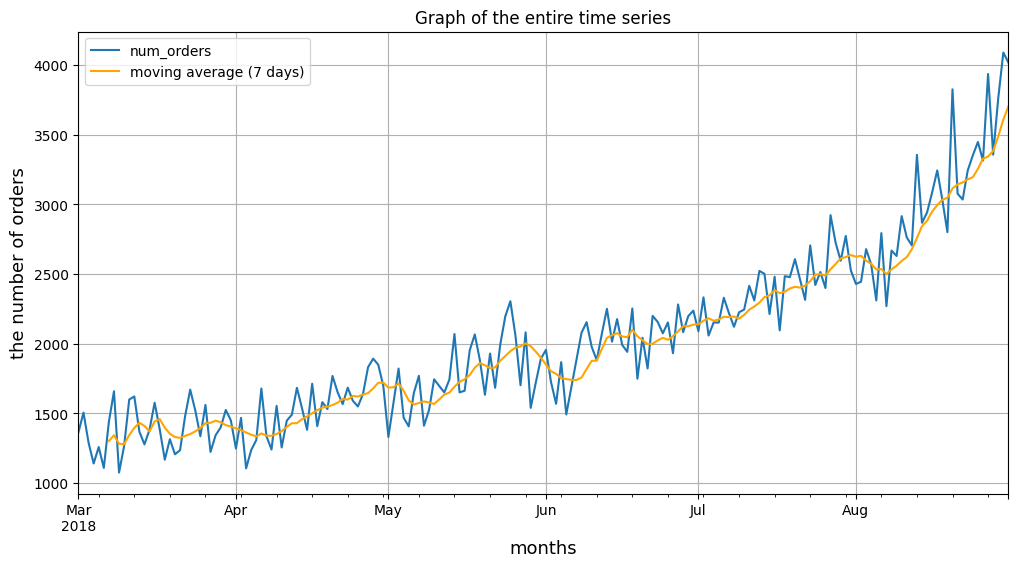

In [9]:
df_taxi_d = df_taxi.resample('1D').sum()
rolling_mean = df_taxi_d.rolling(window=7).mean()

plt.figure(figsize=(12, 6))
df_taxi_d.plot(ax=plt.gca())
plt.plot(rolling_mean, label='moving average (7 days)', color='orange')
plt.title('Graph of the entire time series')
plt.xlabel('months', fontsize=13)
plt.ylabel('the number of orders', fontsize=13)
plt.legend()
plt.grid()
plt.show()

The number of orders is steadily increasing. From March to August, the number of orders increased almost 4 times.

Let's check the seasonality of data within one day, week.

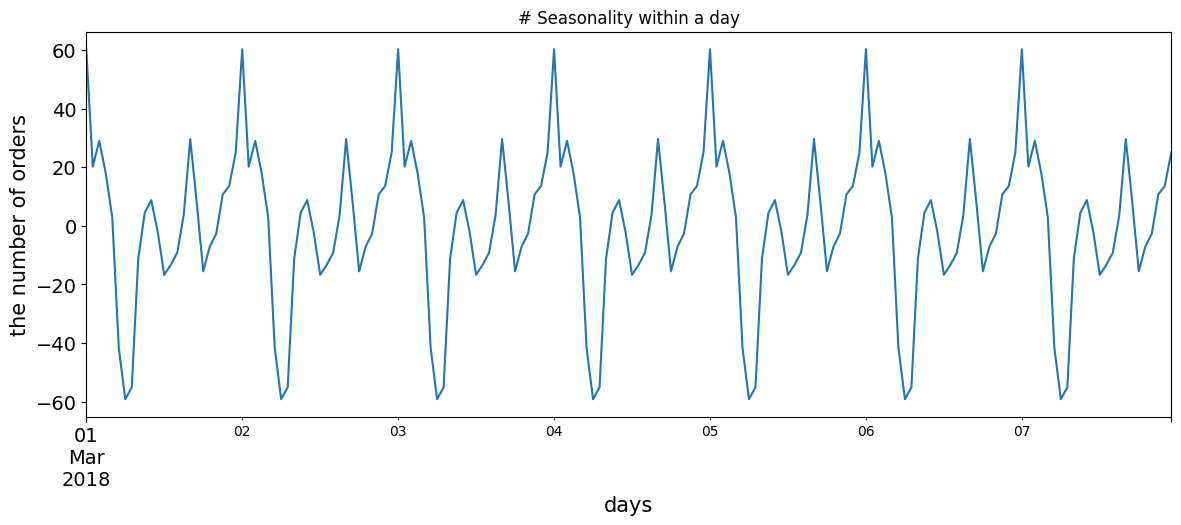

In [10]:
# Seasonality within a day
decomposed = seasonal_decompose(df_taxi_h)
plt.figure(figsize=[14, 5])
ax = decomposed.seasonal.head(168).plot(ax=plt.gca());
plt.title('# Seasonality within a day')
plt.xlabel('days', fontsize=15)
plt.ylabel('the number of orders', fontsize=15)
ax.tick_params(axis='y', labelsize=14) 
ax.tick_params(axis='x', labelsize=14) 
plt.show()

Seasonality within the day is traced, the pattern is repeated from day to day. Perhaps this is due to the fact that at night there are consistently fewer clients, and in the evening, day after day, there are more and more clients. It is worth adding the "hour" feature

In [11]:
df_taxi_h['hour'] = df_taxi_h.index.hour

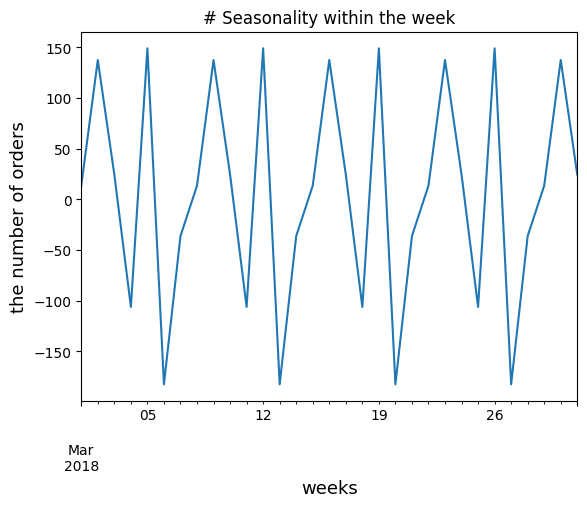

In [12]:
# Seasonality within the week
decomposed = seasonal_decompose(df_taxi_d)
decomposed.seasonal['2018-03'].plot(ax=plt.gca());
plt.title('# Seasonality within the week')
plt.xlabel('weeks', fontsize=13)
plt.ylabel('the number of orders', fontsize=13)
plt.show()

Seasonality is observed within the week. It may be due to the fact that at the beginning of the working week there is a minimum of clients, and closer to the weekend the number of clients increases. It is worth adding the "day of the week" feature.

In [13]:
df_taxi_h['dayofweek'] = df_taxi_h.index.dayofweek

#### Lags

The data is resampled by hours and we noticed seasonality within the day. Let's try to study the autocorrelation of 24 lags.

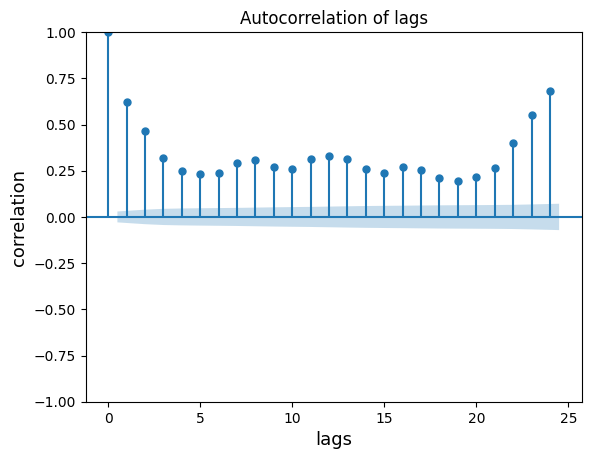

In [14]:
lags = plot_acf(df_taxi_h['num_orders'], lags=24)
plt.title('Autocorrelation of lags')
plt.xlabel('lags', fontsize=13)
plt.ylabel('correlation', fontsize=13)
plt.show()

All lags have a significant level of autocorrelation, let's add all 24 lags as new features.

In [15]:
for lag in range(1, 25):
        df_taxi_h['lag_{}'.format(lag)] = df_taxi_h['num_orders'].shift(lag)

#### Moving average

Let's take a moving average with a window of 24, so we can smooth the data taking into account daily fluctuations.

In [16]:
df_taxi_h['rolling_mean'] = df_taxi_h['num_orders'].shift().rolling(24).mean()

### Stationarity check

Let's conduct the Dickey-Fuller test and perform the KPSS criterion to check the time series for stationarity.

In [17]:
adf_result = adfuller(df_taxi_h['num_orders'])
p = adf_result[1]
alpha = 0.05
if p < alpha:
    print(f'Dickey-Fuller test:\np-value: {p}\n' \
    f'p-value is less than the chosen significance level (0.05).\n' \
    f'We reject the null hypothesis of non-stationarity of the time series.')
else:
    print(f'Dickey-Fuller test:\np-value: {p}\n' \
    f'p-value is not less than the selected significance level (0.05).\n' \
    f'The null hypothesis of non-stationarity of the time series cannot be rejected.')

Dickey-Fuller test:
p-value: 0.028940051402613316
p-value is less than the chosen significance level (0.05).
We reject the null hypothesis of non-stationarity of the time series.


The results of the Dickey-Fuller test suggest that the time series is stationary.

We use the KPSS criterion to test the null hypothesis that

In [18]:
warnings.simplefilter("ignore", category=UserWarning)
kpss_result = kpss(df_taxi_h['num_orders'])
p = kpss_result[1]
if p < alpha:
    print(f'KPSS criterion:\np-value: {p}\n' \
    f'p-value is less than the chosen significance level (0.05).\n' \
    f'We reject the null hypothesis of stationarity of the time series.')
else:
    print(f'KPSS criterion:\np-value: {p}\n' \
    f'p-value is not less than the selected significance level (0.05).\n' \
    f'The null hypothesis of stationarity of the time series cannot be rejected..')


KPSS criterion:
p-value: 0.01
p-value is less than the chosen significance level (0.05).
We reject the null hypothesis of stationarity of the time series.


The KPSS criterion shows that the series is non-stationary.

Considering the general graph of the time series with a clear increase in the average number of orders, as well as the results of the KPSS criterion, it can be assumed that the series is non-stationary.

### Conclusion:
- added as calendar features: hours, days of the week
- added 24 lags
- added a moving average with a window of 24

## Analysis

### Research Analysis

We will analyze the num_orders feature, all added calendar features, the moving average, and the most significant lags

In [19]:
report = sv.analyze([df_taxi_h[['num_orders', 'hour', 'dayofweek', 'lag_1', 'lag_2', \
                                'lag_22', 'lag_23', 'lag_24', 'rolling_mean']], 'Taxi'])

                                             |      | [  0%]   00:00 -> (? left)


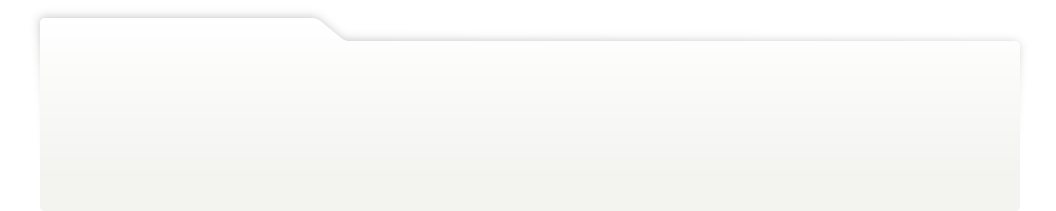
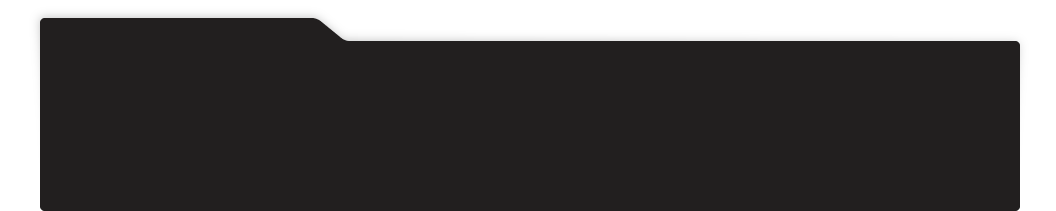
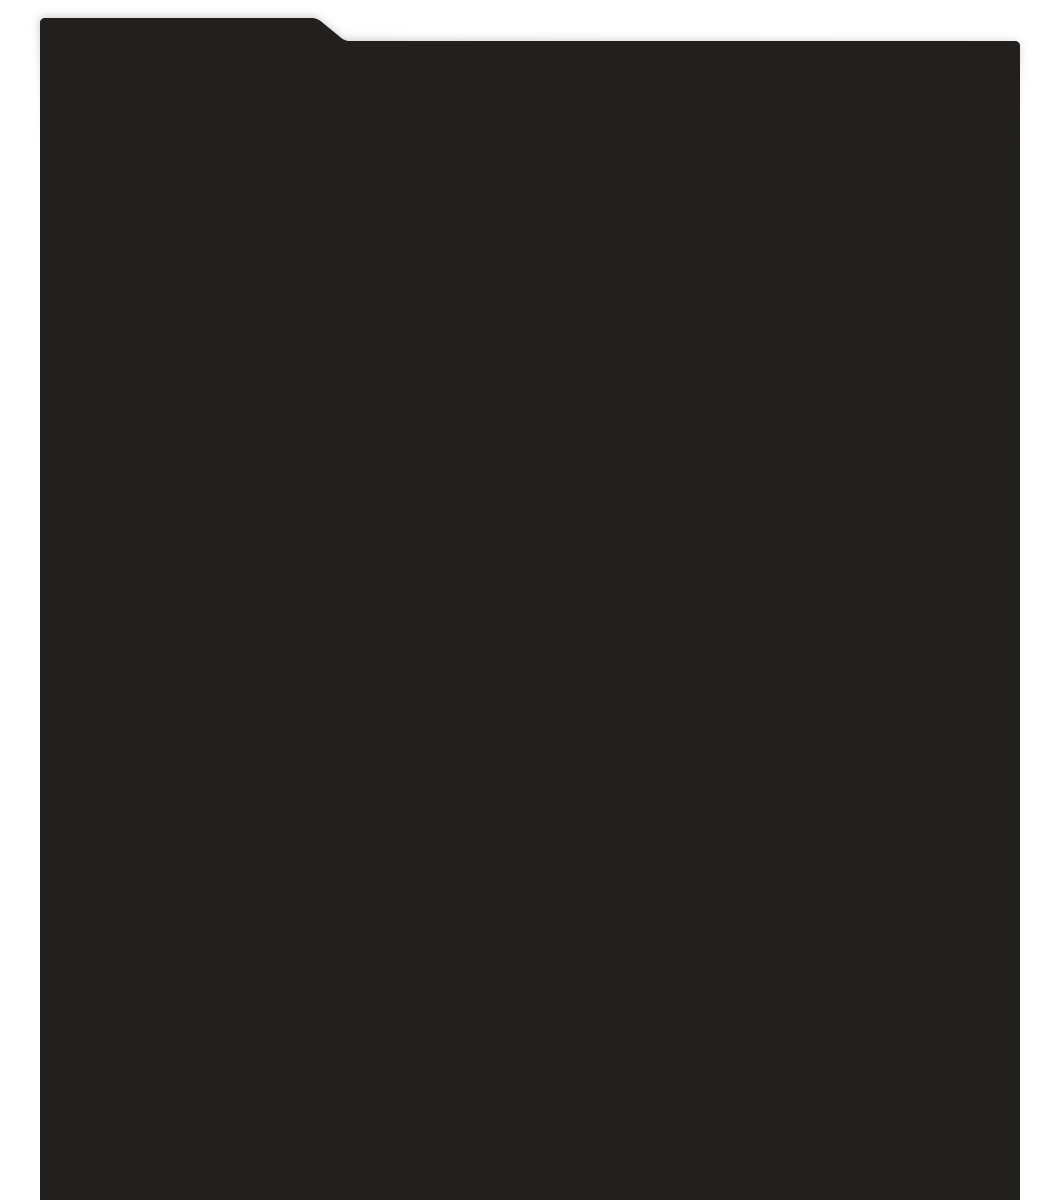
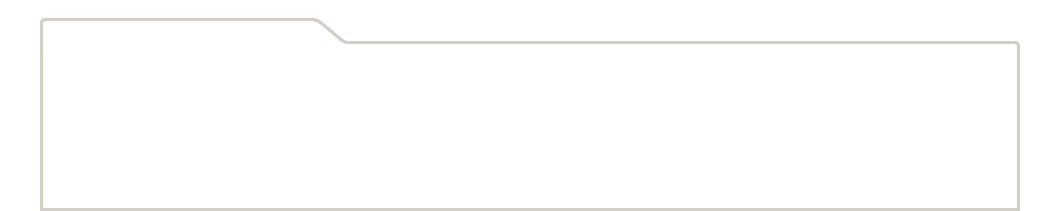
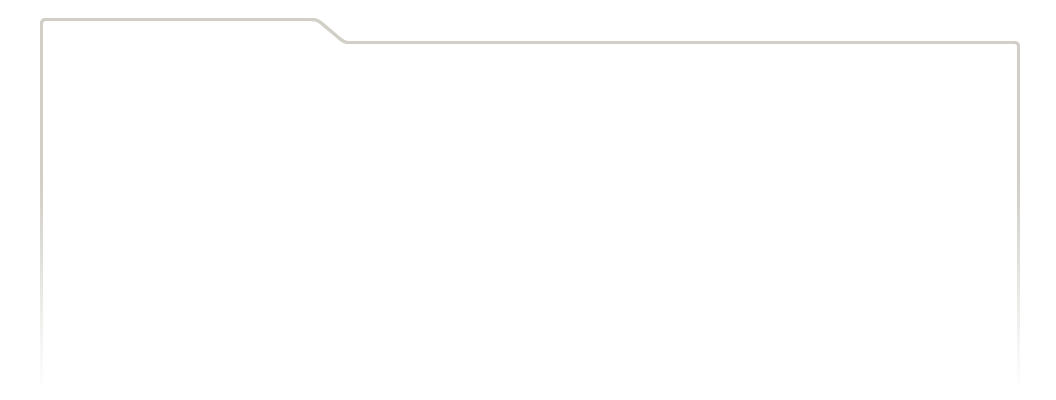
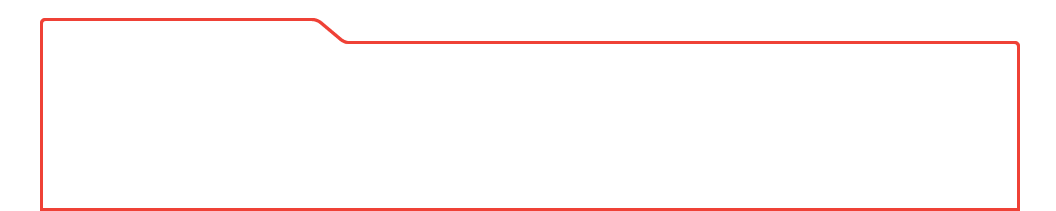
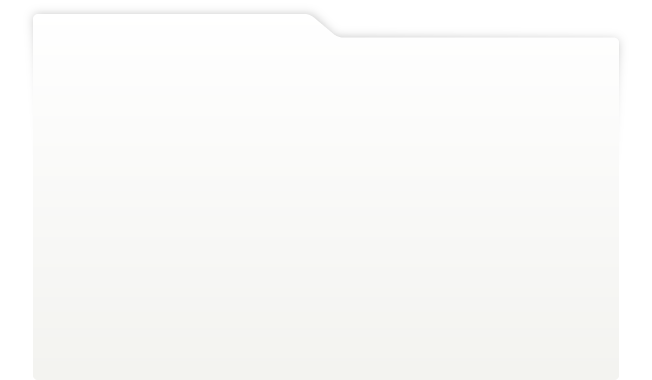
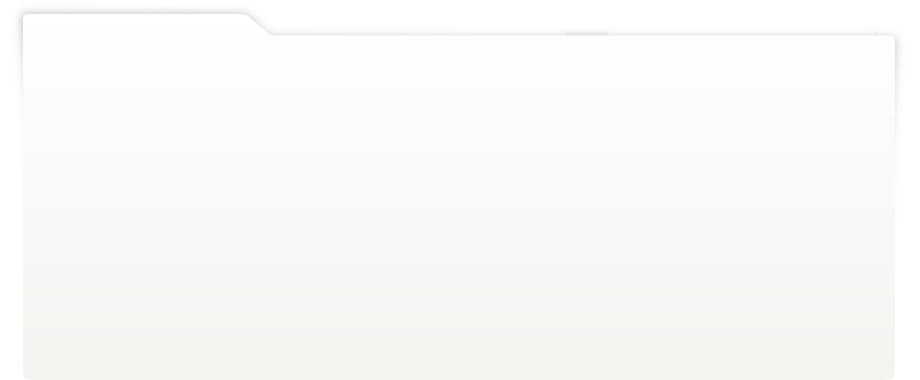
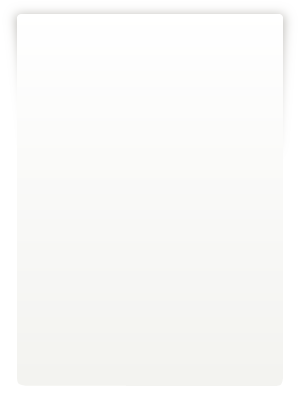
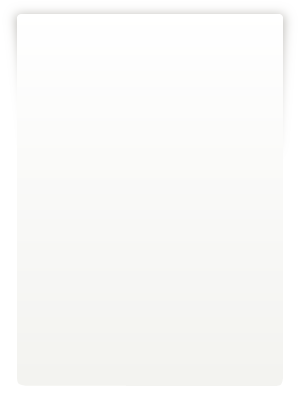
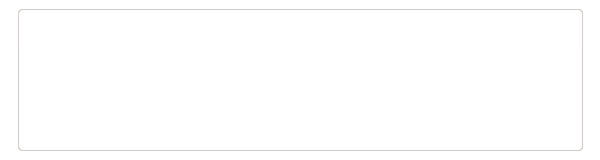
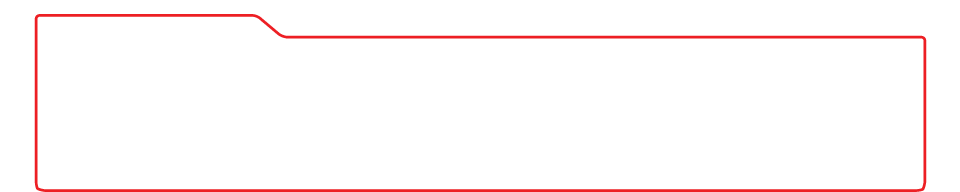
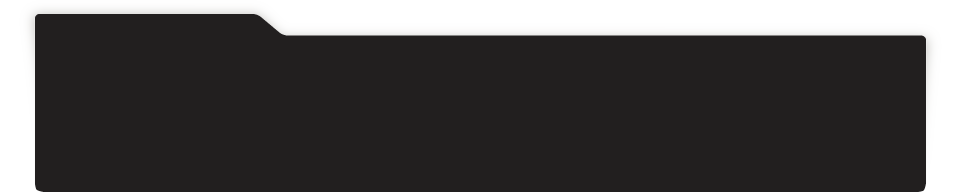
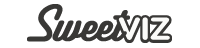
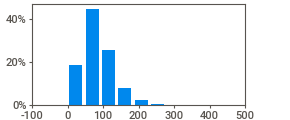
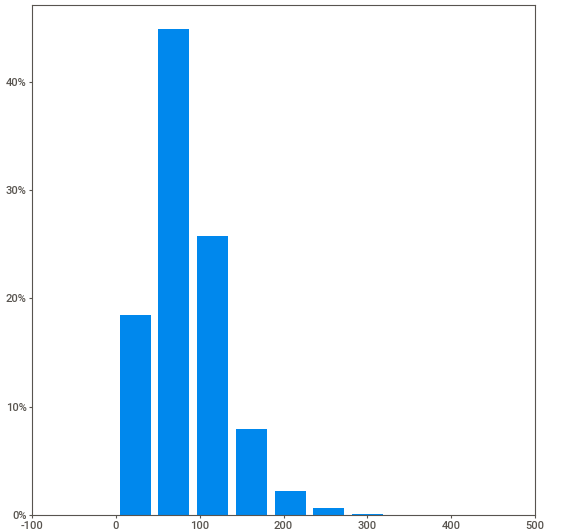
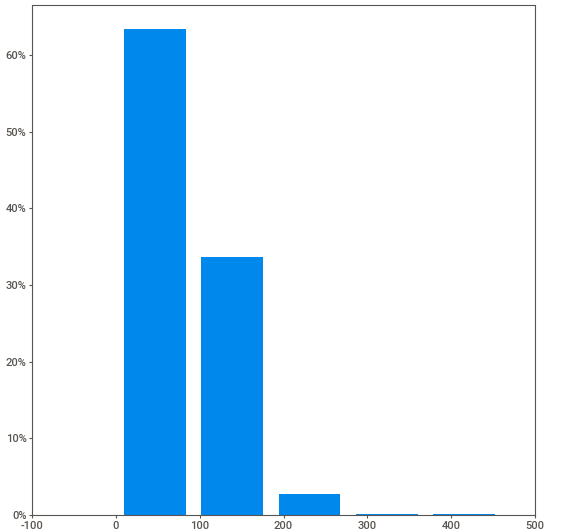
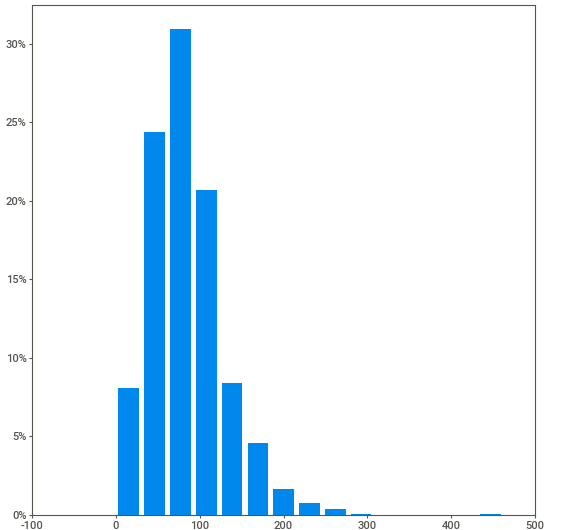
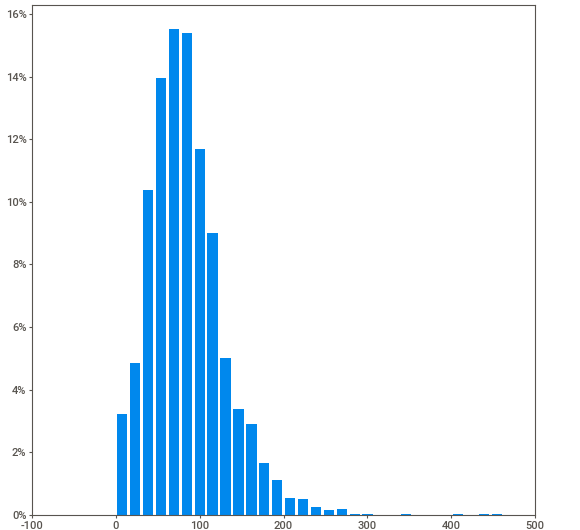
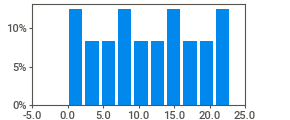
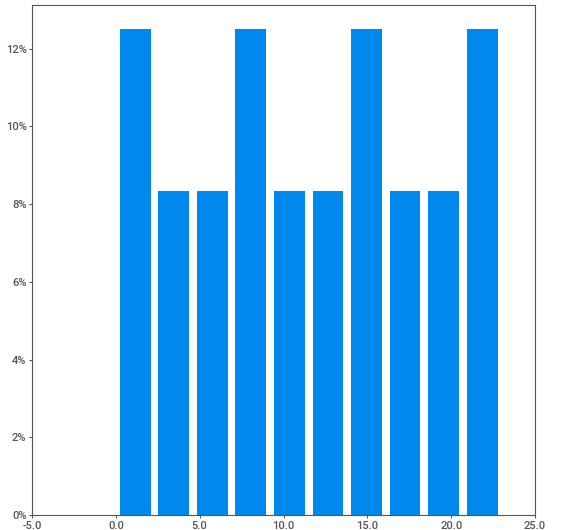
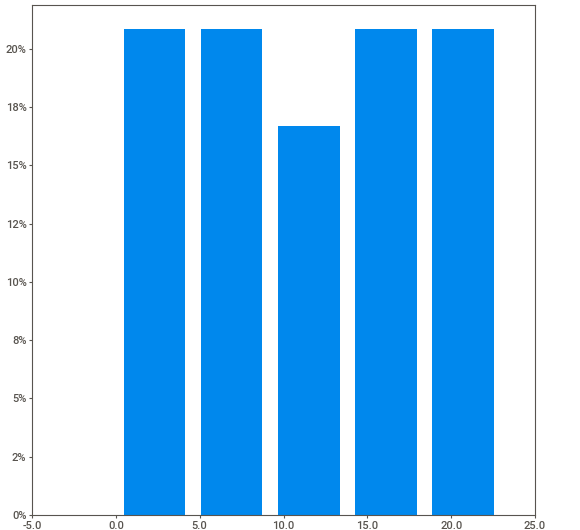
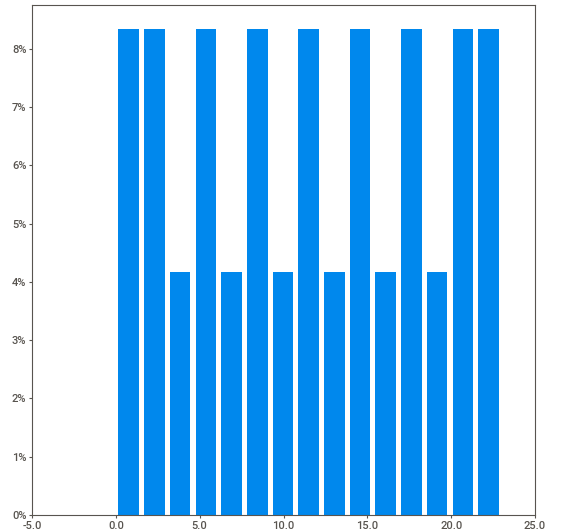
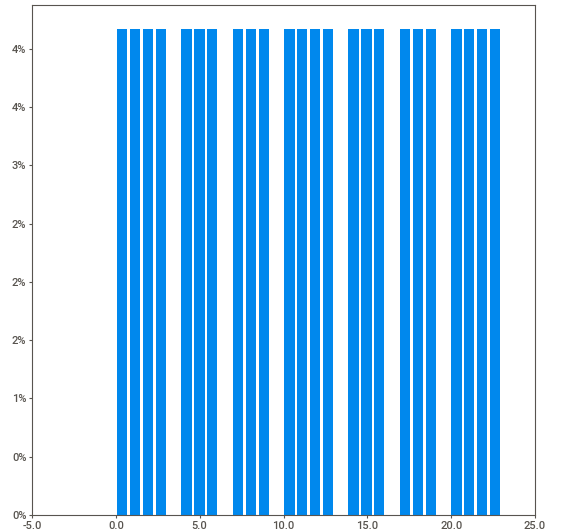
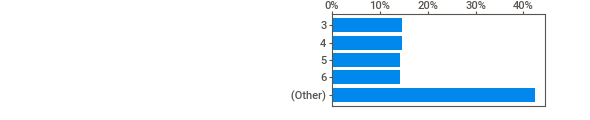
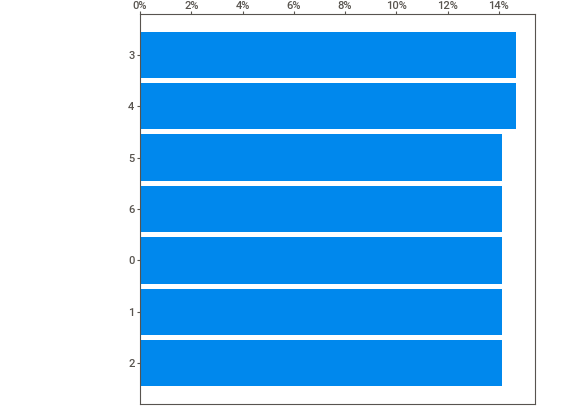
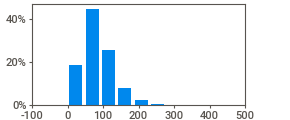
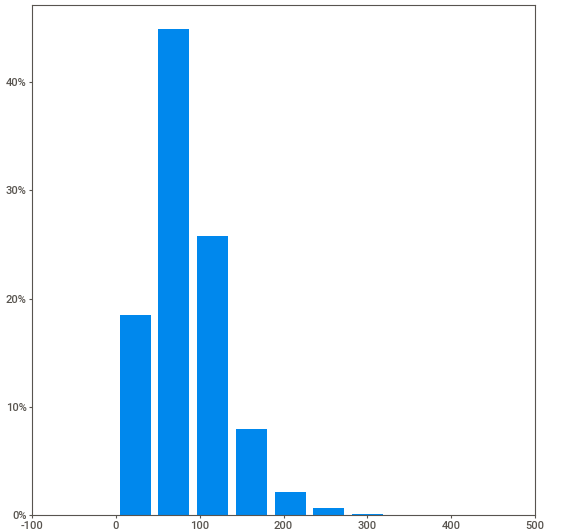
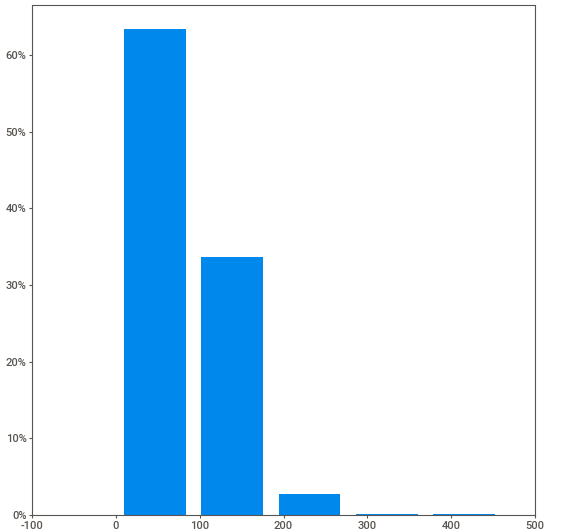
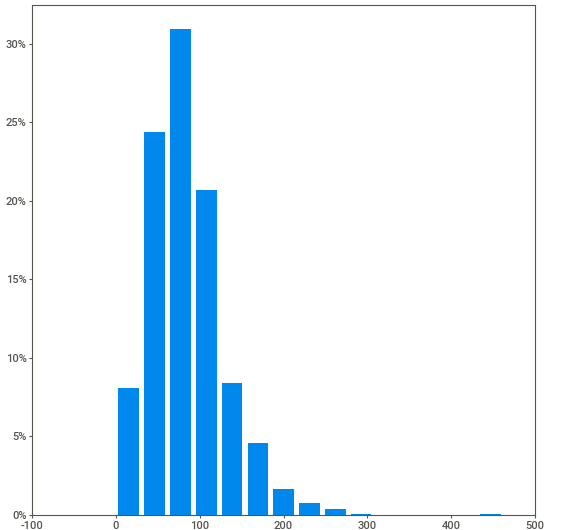
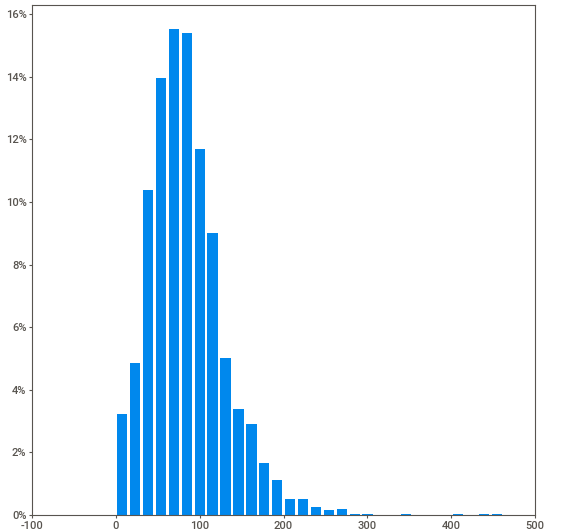
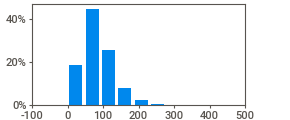
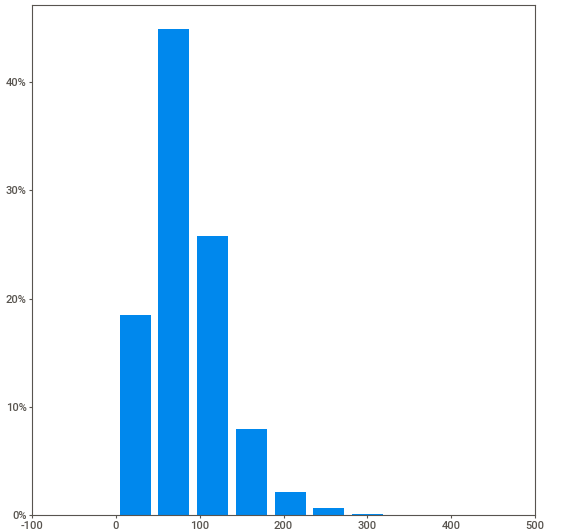
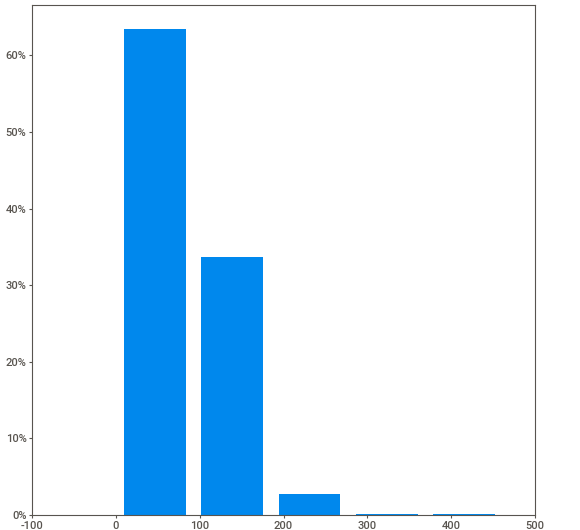
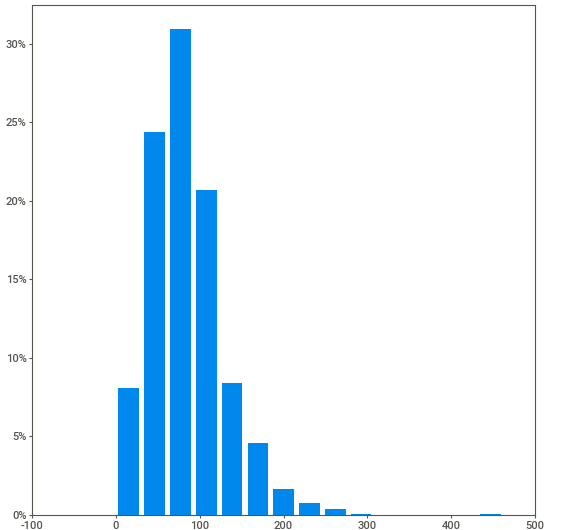
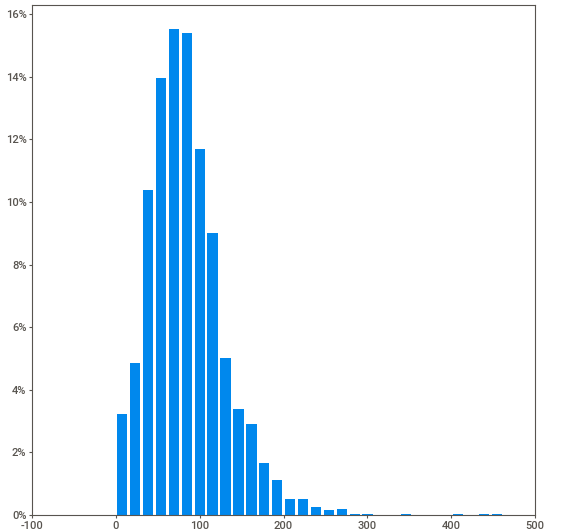
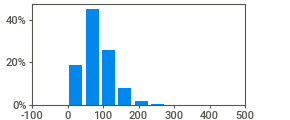
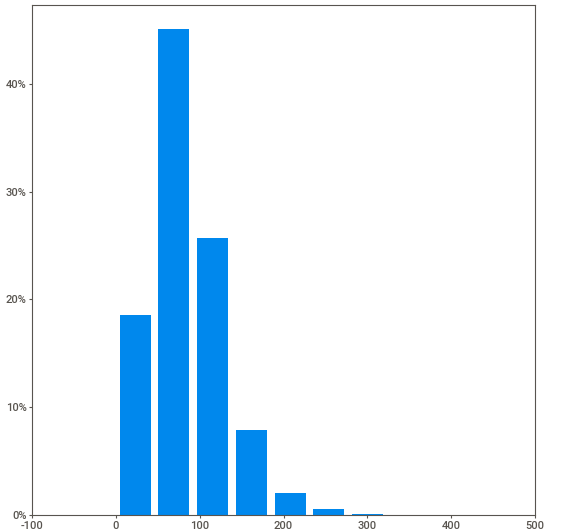
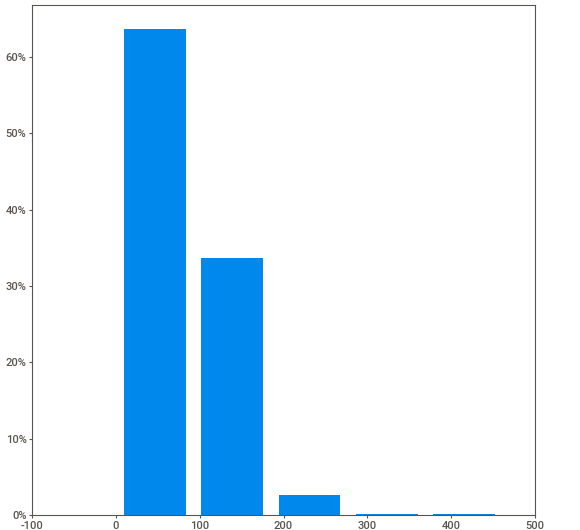
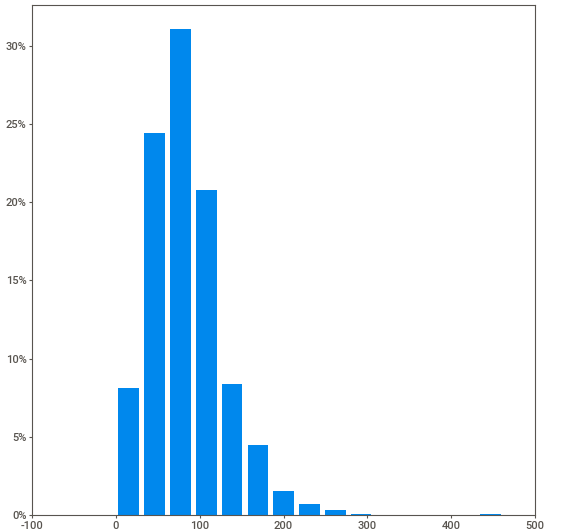
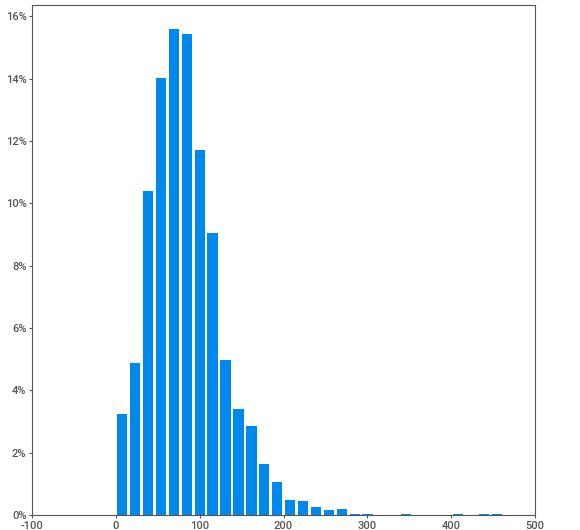
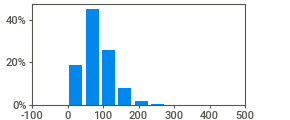
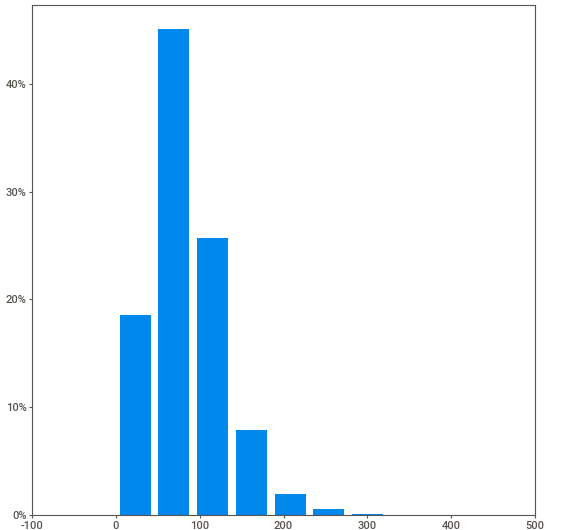
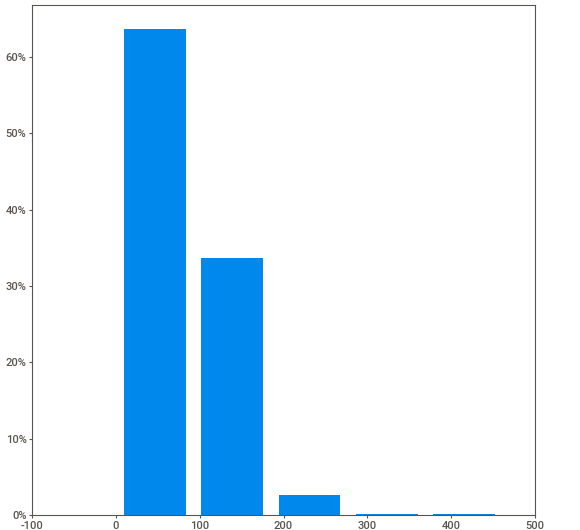
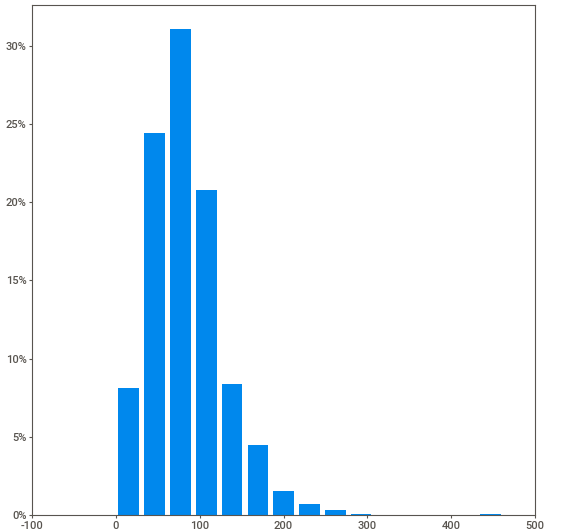
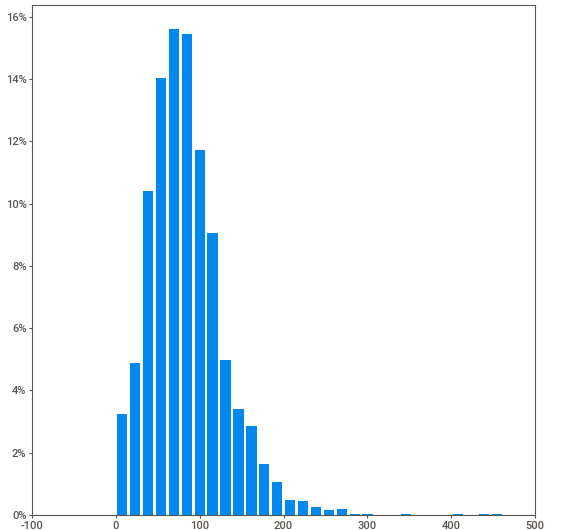
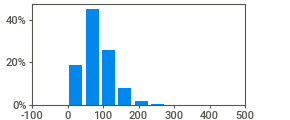
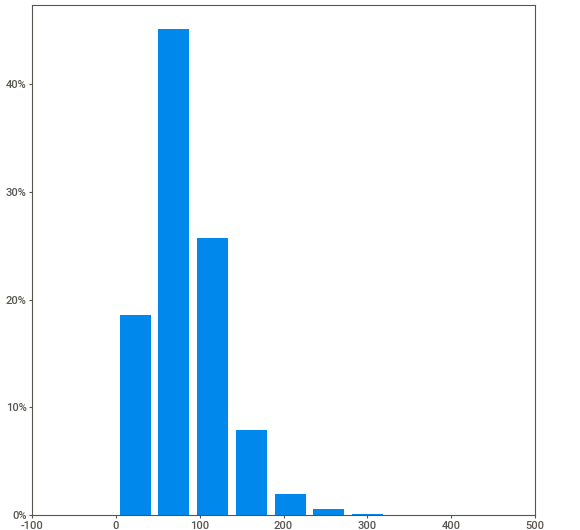
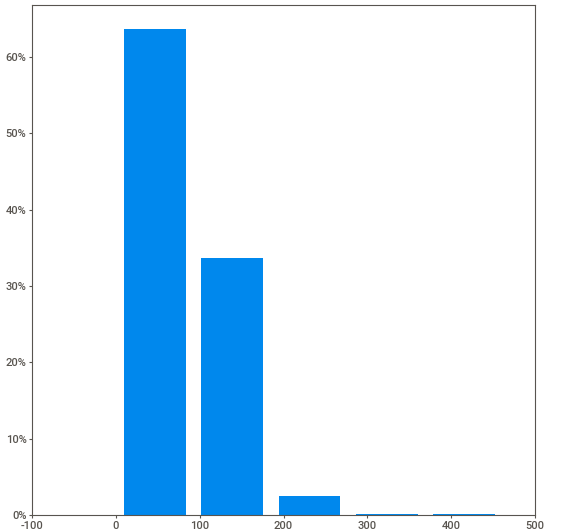
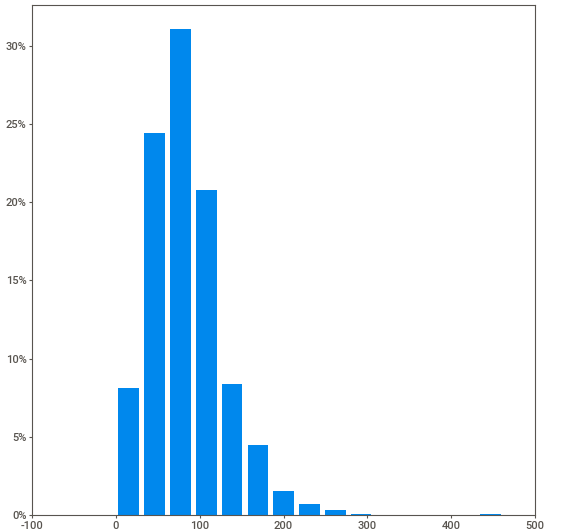
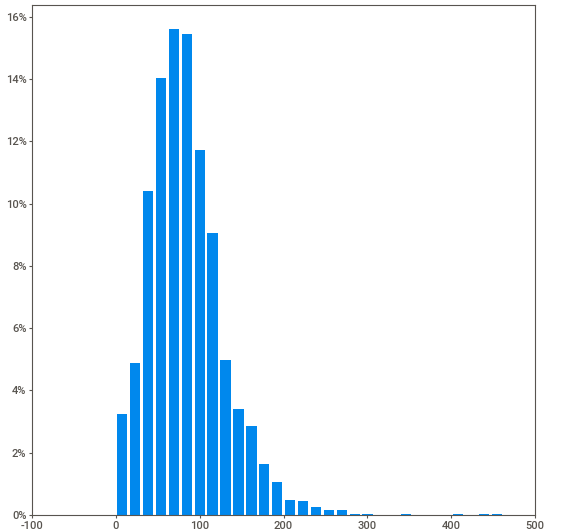
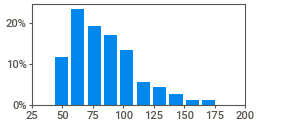
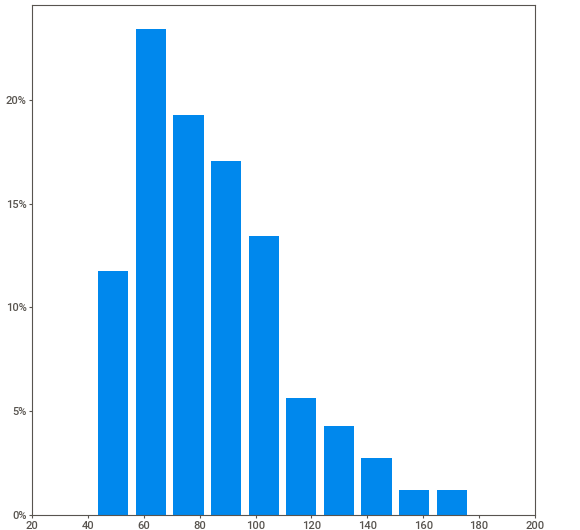
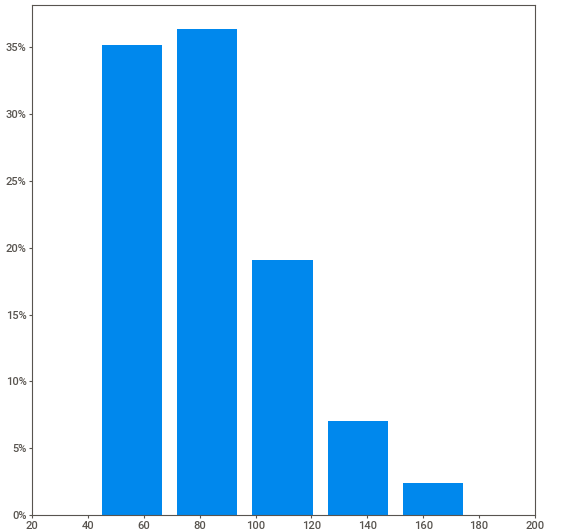
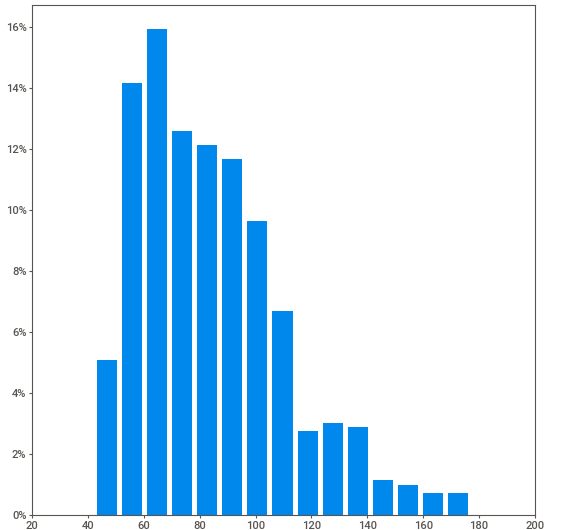
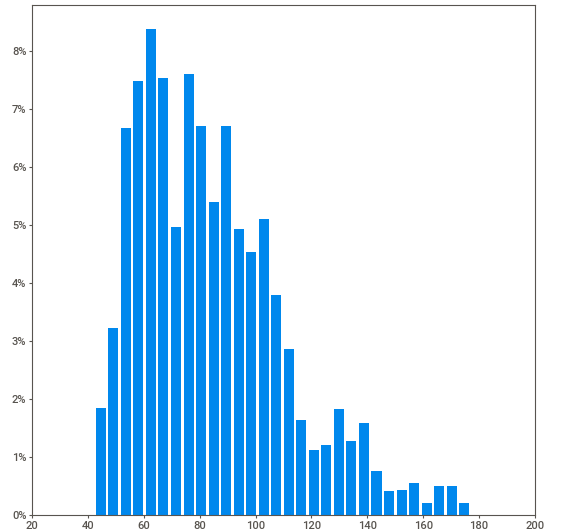
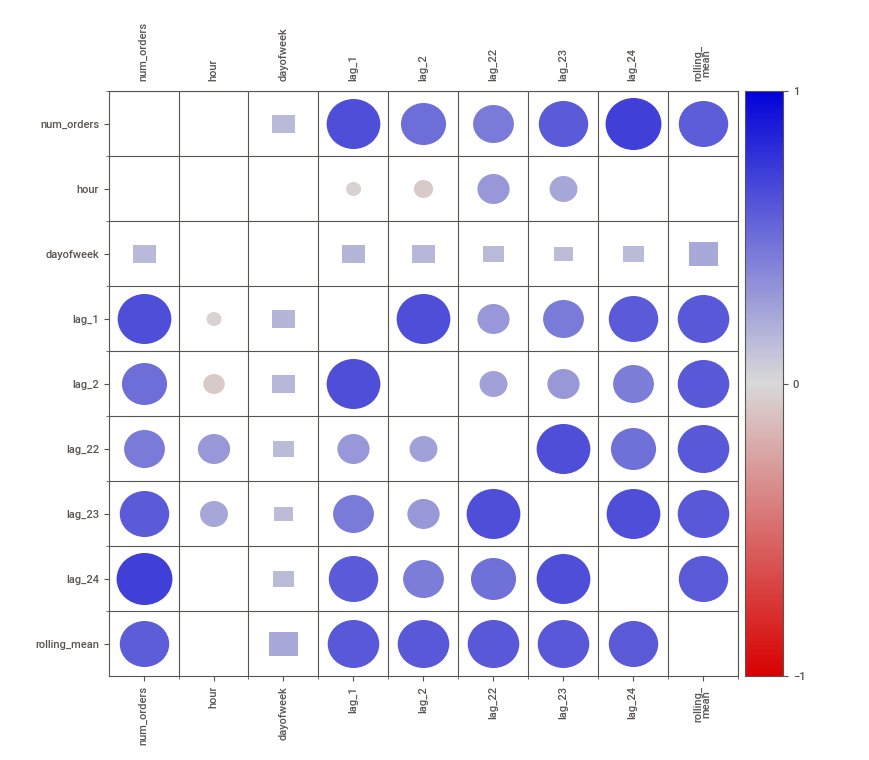
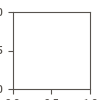

In [20]:
report.show_notebook()

Gaps appeared due to the inclusion of lags as features. The correlation between the target feature and the lags can be immediately seen. The distributions of quantitative features are not normal.

Let's build boxplots to track outliers and outliers.

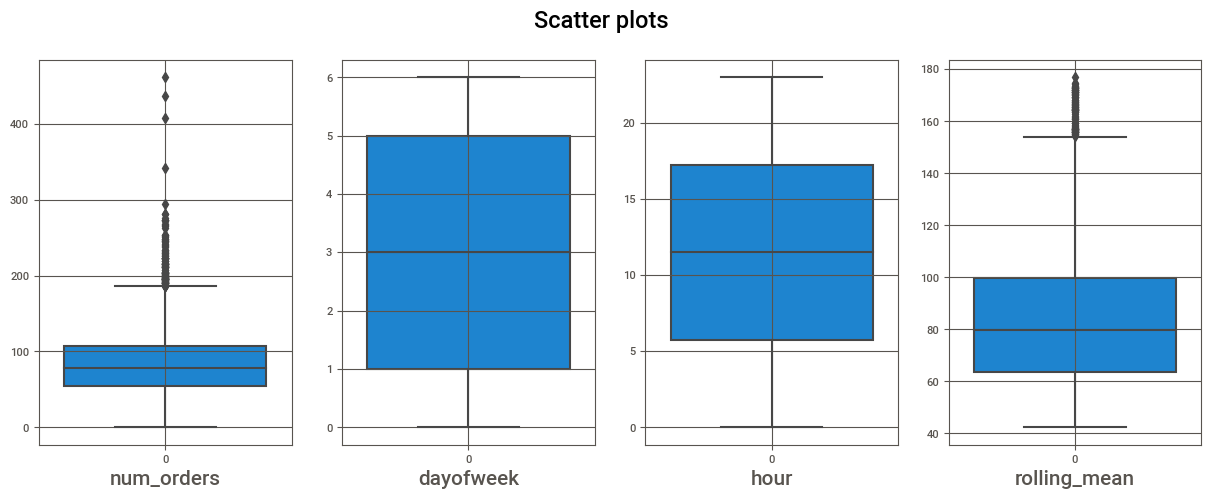

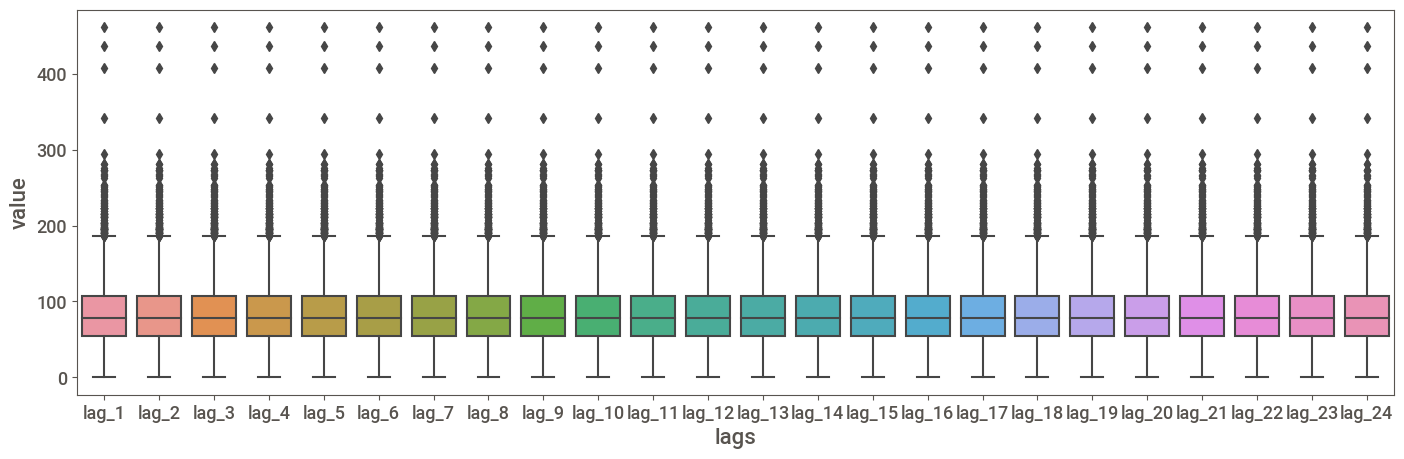

In [21]:
plt.figure(figsize=[15, 5])
plt.suptitle('Scatter plots', size=17)
df_box = df_taxi_h[['num_orders', 'dayofweek', 'hour', 'rolling_mean']]
df_melted = df_taxi_h.iloc[:, 3:27].melt(var_name='lags', value_name='Value')

for i in range(4):
    plt.subplot(1, 4, i+1)
    sns.boxplot(data=df_box.iloc[:, i])
    plt.xlabel(df_box.columns[i], size=15)
    plt.grid()
plt.show()

plt.figure(figsize=[17, 5])
ax = sns.boxplot(x='lags', y='Value', data=df_melted)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlabel('lags', fontsize=16)
ax.set_ylabel('value', fontsize=16)
plt.show()

There are outliers in some features, but we will not remove them in order to preserve the consistency of the time series.

### Correlation analysis

Let's study the correlation of features in more detail (we take the most significant lags)

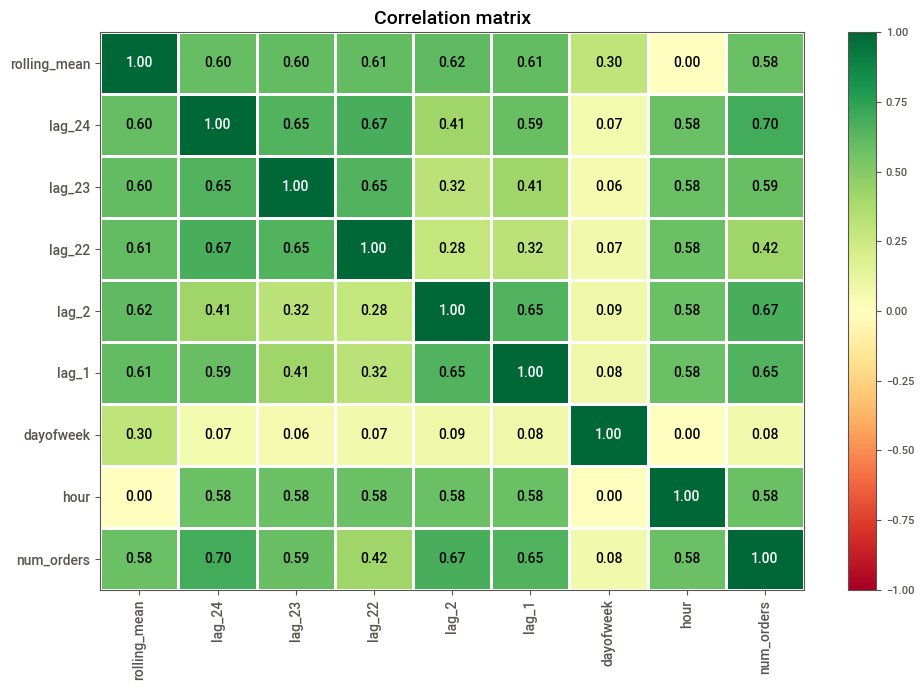

In [22]:
df_taxi_corr = df_taxi_h[['num_orders', 'hour', 'dayofweek', 'lag_1', 'lag_2', \
                          'lag_22', 'lag_23', 'lag_24', 'rolling_mean']].dropna()
corr_matrix = phik_matrix(df_taxi_corr, interval_cols=df_taxi_corr.drop(['dayofweek', 'hour'], axis=1).columns)

plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index, \
                        title='Correlation matrix', figsize=(10, 7))

The matrix shows good correlation with all the selected features except dayofweek. No multicollinearity is observed.

### Conclusion:
- gaps in features appeared
- distribution of quantitative features is abnormal
- outliers in the data were noticed, but it was decided not to remove them
- all features except dayofweek correlate well with the target feature

## Education

Let's select samples

In [23]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(df_taxi_h.drop('num_orders', axis=1), 
                                                    df_taxi_h['num_orders'],
                                                    shuffle=False,
                                                    test_size=TEST_SIZE)

Pipelines for working with features

In [24]:
num_col = X_train.drop(['hour', 'dayofweek'], axis=1).columns.tolist()
cat_col = ['hour', 'dayofweek']

num_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler())
    ]
)


cat_pipe = Pipeline(
    [
        ('imputer_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder', OrdinalEncoder()) 
                                      
    ]
)

In [25]:
preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_col), 
        ('cat', cat_pipe, cat_col),
    ], 
    remainder='passthrough'
)

In [26]:
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ])

Enumeration of models and their hyperparameters

In [27]:
param_grid = [
    {
         'model': [Lasso(random_state=RANDOM_STATE)],
         'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
     },
    {
        'model': [Ridge(random_state=RANDOM_STATE)],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
     {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': range(2, 5),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
     },
    {
        'model':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 5),
        'preprocessor__num': ['passthrough']
    },
      {
        'model':  [LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
         'model__boosting_type': ['gbdt', 'dart'],
         'model__num_leaves': range(20,30),
         'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
     }
]

In [28]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

We use TimeSeriesSplit because we work with time series. It is important to preserve the chronological order and take into account the temporal dependence of the data

In [29]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
search = RandomizedSearchCV(pipe_final, param_grid, cv=tscv, scoring=scorer, n_jobs=-1, random_state=RANDOM_STATE)
search.fit(X_train, y_train)

CPU times: user 675 ms, sys: 31.5 ms, total: 707 ms
Wall time: 8.6 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag_9',
                                                                                'lag_10...
                                         'model__max_depth': range(2, 5),
                                         'preprocessor__num': ['passthrough']},
                                        {'model': [LGBMRegressor(random_state=42,
                                                                 verbose=-1)],
                                         'model__boosting_type': ['gbdt',
                                                                  'dart'],
                                         'model__num_leaves': range(20, 30),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [30]:
search.best_score_ * -1

24.8512874626876

RMSE of the best model is 24.8. The best model is LGBMRegressor(num_leaves=23, random_state=42)

### Conclusion:
- split into samples, making a test sample of 10% of the original data
- iterated through many models using RandomizedSearchCV() and used TimeSeriesSplit() as a cross-validation method.
- got an RMSE of 24.8 for the best model LGBMRegressor(num_leaves=23, random_state=42)

## Testing

Let's calculate RMSE on the test sample for the best model

In [31]:
best_model = search.best_estimator_
result = best_model.predict(X_test)

In [32]:
rmse(y_test, result)

41.85504778311295

RMSE shows a worse result on the test sample than on the training sample, but still less than 48.

Let's study the significance of the features

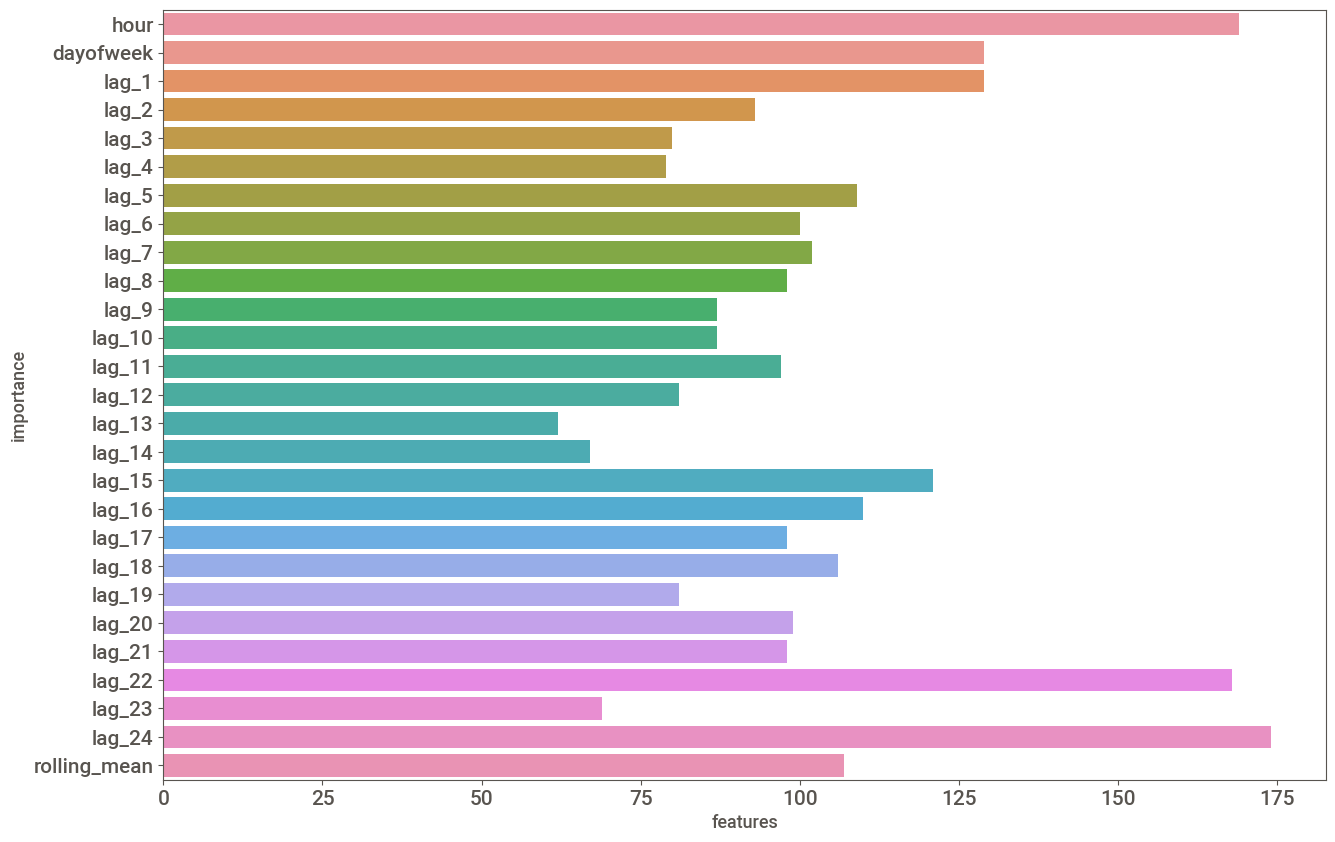

In [33]:
best_model = search.best_estimator_.named_steps['model']
feature_importances = best_model.feature_importances_

dd = pd.DataFrame(feature_importances, X_test.columns).reset_index()
plt.figure(figsize=(15, 10));
ax = sns.barplot(y=dd['index'], x=dd[0], orient='h');
plt.xlabel('features', fontsize=13);
plt.ylabel('importance', fontsize=13);
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15) 

### Conclusion:
- the RMSE indicator on the test sample has worsened (41.8), but within acceptable limits.
- we found that all the features used are significant enough to predict the number of taxi orders for the next hour. The most significant are hour, lag_22 and lag_24

## ***General conclusion***

    Main task:

        Build a model to predict the number of taxi orders for the next hour.

    Work stages:
        1. Data preparation:
            - downloaded data, setting dates as indices.
            - created new features, such as hour, day of the week, 24 lags and a moving average with a window of 24
            - checked the data for stationarity using the Dickey-Fuller test and the KPSS criterion
        2. Data analysis: conducted exploratory and correlation analysis
        3. Model training:
            - split the data into samples, making a test sample of 10% of the original data.
            - went through many models using RandomizedSearchCV() and used TimeSeriesSplit() as a cross-validation method.
            - got RMSE equal to 24.8 for the best model LGBMRegressor(num_leaves=23, random_state=42)
        4. Testing:
            - calculated rmse value on the test sample, got 41.8 (within normal limits)
            - studied the significance of all features. All created features turned out to be quite significant.

**Best model: LGBMRegressor(num_leaves=23, random_state=42) with rmse value on the test sample of 41.8**